In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split, cross_validate

from sklearn.svm import SVC

from PIL import Image

import time


In [2]:
train_set = pd.read_csv('mnist_train.csv', header = None)
test_set = pd.read_csv('mnist_test.csv', header = None)

train_set.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X_train = train_set.loc[:,1:]
y_train = train_set.loc[:,0]
X_test = test_set.loc[:,1:]
y_test = test_set.loc[:,0]

X_train_array = X_train.values
X_test_array = X_test.values
y_train_array = y_train.values
y_test_array = y_test.values

### Deskewing the data
code from: https://fsix.github.io/mnist/Deskewing.html

In [4]:
from scipy.ndimage import interpolation

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    img = interpolation.affine_transform(image,affine,offset=offset)
    return (img - img.min()) / (img.max() - img.min())

In [5]:
examples = (4181, 0), (3,1), (56282, 2), (25829,3), (9741,4) , (26901,5), (50027,6), (17935,7) , (41495, 8), (14662, 9)

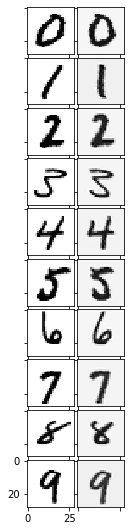

In [6]:
from mpl_toolkits.axes_grid1 import AxesGrid
grid = AxesGrid(plt.figure(figsize=(8,15)), 141,  # similar to subplot(141)
                    nrows_ncols=(10, 2),
                    axes_pad=0.05,
                    label_mode="1",
                    )

for examplenum,num in examples:
    im = grid[2*num].imshow(X_train_array[examplenum].reshape(28,28),cmap='Greys')
    im2 = grid[2*num+1].imshow(deskew(X_train_array[examplenum].reshape(28,28)),cmap='Greys')


In [7]:
def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)

X_train_deskewed = deskewAll(X_train_array)
X_test_deskewed = deskewAll(X_test_array)

## Skewed vs. Deskewed

In [13]:
start = time.time()

svc_original = SVC()
svc_deskewed = SVC()

svc_original.fit(X_train, y_train)
svc_deskewed.fit(X_train_deskewed, y_train)

print('SVC Error %: ', (1-svc_original.score(X_test, y_test))*100)
print('SVC Error % ', (1-svc_deskewed.score(X_test_deskewed, y_test))*100)
print('SVC Error % with deskewing only train data: ', (1-svc_deskewed.score(X_test, y_test))*100)
print((time.time() - start)/60, 'minutes')

SVC Error %: 	 	 2.080000000000004
SVC Error % with deskewing train and test data: 	 	 1.3800000000000034
SVC Error % with deskewing only train data: 	 	 89.68
14.356088594595592 minutes


## Choosing the Kernel
### (Start with C = 1)

In [8]:
start = time.time()

kernels = ['linear', 'poly', 'sigmoid']

scores_kernel = np.zeros(3)
for j in range(3):
    svc = SVC(kernel = kernels[j])
    svc.fit(X_train_deskewed, y_train)
    scores_kernel[j]=(1-svc.score(X_test_deskewed, y_test))*100
    
print(scores_kernel)
print('Best Kernel:', kernels[np.argmin(scores_kernel)])
print('Error %:', np.min(scores_kernel))

print((time.time() - start)/60, 'minutes')

[ 3.62  1.35 30.44]
Best Kernel: poly
Error %: 1.3499999999999956
22.817512281735738 minutes


# Kernel = Poly
## Trying various degrees with C = 1

### With original data

In [9]:
from tqdm import tqdm
start = time.time()

scores_poly_orig = np.empty(12)
for i in tqdm(range(12)):
    svc = SVC(C = 1, kernel = 'poly', degree = i+1 )
    svc.fit(X_train, y_train)
    scores_poly_orig[i]=(1-svc.score(X_test, y_test))*100
    

print(scores_poly_orig)
print('Best Poly Degree:', np.argmin(scores_poly_orig) + 1)
print('Error %:', np.min(scores_poly_orig))

print((time.time() - start)/60, 'minutes')

100%|██████████| 12/12 [3:54:31<00:00, 1172.63s/it] 

[ 5.55  2.26  2.29  3.02  4.39  6.26  8.68 11.35 14.19 17.27 20.14 22.89]
Best Poly Degree: 2
Error %: 2.2599999999999953
234.52503439982732 minutes


### With deskewed data

In [8]:
from tqdm import tqdm
start = time.time()

scores_poly = np.empty(12)
for i in tqdm(range(12)):
    svc = SVC(C = 1, kernel = 'poly', degree = i+1 )
    svc.fit(X_train_deskewed, y_train)
    scores_poly[i]=(1-svc.score(X_test_deskewed, y_test))*100
    

print(scores_poly)
print('Best Poly Degree:', np.argmin(scores_poly) + 1)
print('Error %:', np.min(scores_poly))

print((time.time() - start)/60, 'minutes')

100%|██████████| 12/12 [1:17:09<00:00, 385.79s/it]

[3.24 1.56 1.35 1.38 1.56 1.83 2.1  2.54 3.12 3.83 4.51 5.2 ]
Best Poly Degree: 3
Error %: 1.3499999999999956
77.15875246922175 minutes


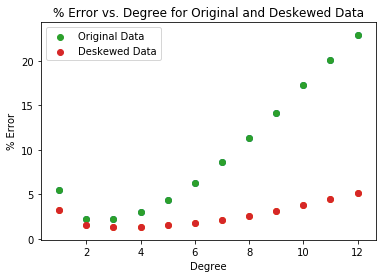

In [54]:
degrees = [1,2,3,4,5,6,7,8,9,10,11,12]
skewed = [ 5.55,  2.26,  2.29,  3.02,  4.39,  6.26,  8.68, 11.35, 14.19, 17.27, 20.14, 22.89]
deskewed = [3.24, 1.56, 1.35, 1.38, 1.56, 1.83, 2.1,  2.54, 3.12, 3.83, 4.51, 5.2 ]
plt.scatter(degrees, skewed)
plt.scatter(degrees, deskewed)
plt.xlabel('Degree')
plt.ylabel('% Error')
plt.legend((plt.scatter(degrees, skewed), plt.scatter(degrees, deskewed)), ('Original Data', 'Deskewed Data'))
plt.title('% Error vs. Degree for Original and Deskewed Data')
plt.savefig('Degree vs Error')
plt.show()


## Translating our Data
references: Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts By Aurélien Géron, https://www2.eecs.berkeley.edu/Pubs/TechRpts/2009/EECS-2009-159.pdf, 
http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf,
https://people.eecs.berkeley.edu/~malik/cs294/decoste-scholkopf.pdf

code from: https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb

In [8]:
from scipy.ndimage.interpolation import shift

In [9]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

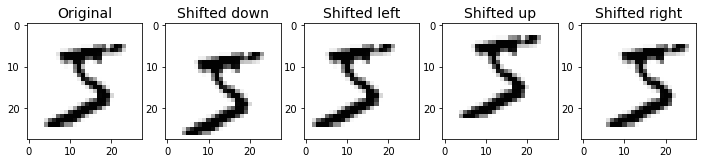

In [10]:
image = X_train_array[0]
shifted_image_down = shift_image(image, 0, 2)
shifted_image_left = shift_image(image, -2, 0)

shifted_image_up = shift_image(image, 0, -2)
shifted_image_right = shift_image(image, 2, 0)


plt.figure(figsize=(12,5))
plt.subplot(151)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(152)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(153)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(154)
plt.title("Shifted up", fontsize=14)
plt.imshow(shifted_image_up.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(155)
plt.title("Shifted right", fontsize=14)
plt.imshow(shifted_image_right.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

## 1-Pixel Translation with Poly Kernel Various Degrees.
### Deskewed, C = 2

In [11]:
X_train_augmented = [image for image in X_train_deskewed]
y_train_augmented = [label for label in y_train_array]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train_deskewed, y_train_array):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

X_train_augmented.shape

(300000, 784)

In [12]:
from tqdm import tqdm
start = time.time()

scores_poly = np.empty(10)

for i in tqdm(range(10)):
    svc = SVC(C = 2, kernel = 'poly', degree = i+1 )
    svc.fit(X_train_augmented, y_train_augmented)
    scores_poly[i]=(1-svc.score(X_test_deskewed, y_test))*100
    

print(scores_poly)
print('Best Poly Degree:', np.argmin(scores_poly) + 1)
print('Error %:', np.min(scores_poly))

print((time.time() - start)/60, 'minutes')

100%|██████████| 10/10 [16:59:16<00:00, 6115.67s/it] 

[3.22 0.9  0.84 0.97 1.06 1.19 1.41 1.66 1.93 2.26]
Best Poly Degree: 3
Error %: 0.8399999999999963
1019.2795423150062 minutes


### Confusion Matrix For Degree 3 polynomial
https://www.geeksforgeeks.org/confusion-matrix-machine-learning/

Rows represent the actual numbers. Columns represent the predicted numbers.

In [12]:
start = time.time()

svc = SVC(C = 2, kernel = 'poly', degree = 3)
svc.fit(X_train_augmented, y_train_augmented)

print('Degree 3 Poly SVC 1 pixel translation Error % : ',(1-svc.score(X_test_deskewed, y_test))*100)

print((time.time() - start)/60, 'minutes')

Degree 3 Poly SVC 1 pixel translation Error % :  0.8399999999999963
118.54125968217849 minutes


In [13]:
from sklearn.metrics import confusion_matrix


test_predictions = svc.predict(X_test_deskewed)
confusion = confusion_matrix(y_test, test_predictions)
print(confusion)

[[ 977    0    1    0    0    0    1    1    0    0]
 [   0 1131    1    0    0    1    2    0    0    0]
 [   2    4 1019    1    1    0    1    1    3    0]
 [   0    0    0 1005    0    2    0    2    0    1]
 [   0    0    0    0  975    0    4    0    1    2]
 [   1    0    0    4    0  882    2    1    1    1]
 [   2    1    0    0    3    3  948    0    1    0]
 [   2    0    3    1    0    0    0 1020    0    2]
 [   2    0    1    0    1    2    0    1  967    0]
 [   0    1    0    2    7    3    0    4    0  992]]


In [14]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

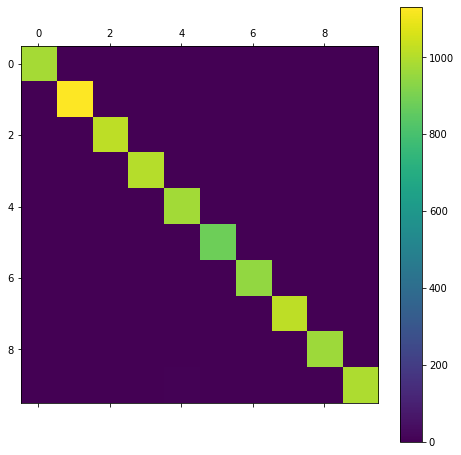

In [15]:
plot_confusion_matrix(confusion)

In [16]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

def false_positive(num):
    for i in range(10):
        if i != num:
            if np.sum([(y_test == i) & (test_predictions == num)])>0:
                X = X_test_deskewed[(y_test == i) & (test_predictions == num)] 
                plot_digits(X[:25], images_per_row=5)
                plt.title(('Predicted:',num, 'Actual:',i))
                plt.show()
            
def false_negative(num2):
    for i in range(10):
        if i != num2:
            if np.sum([(y_test == num2) & (test_predictions == i)])>0:
                X = X_test_deskewed[(y_test == num2) & (test_predictions == i)] 
                plot_digits(X[:25], images_per_row=5)
                plt.title(('Predicted:',i, 'Actual:',num2))
                plt.show()   

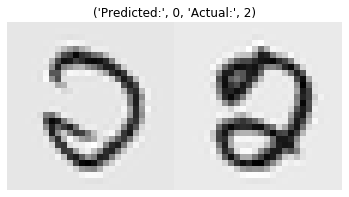

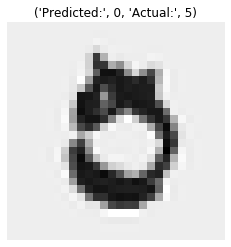

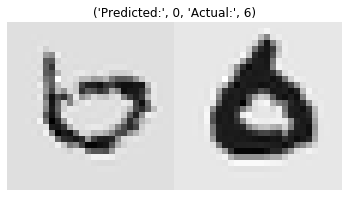

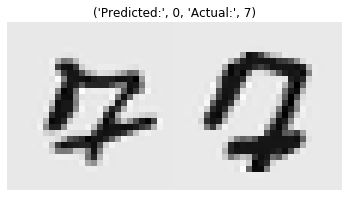

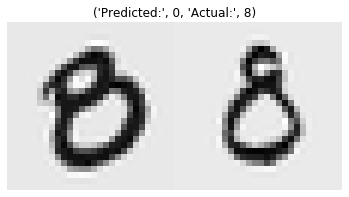

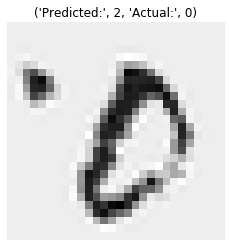

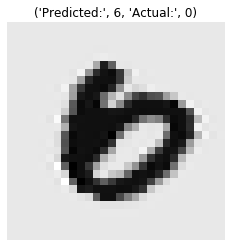

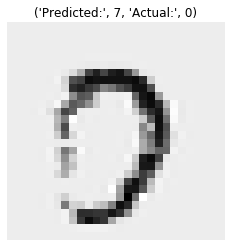

In [18]:
false_positive(0)
false_negative(0)

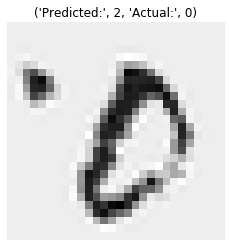

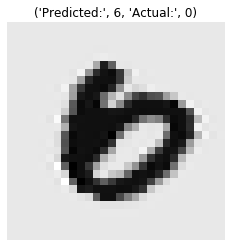

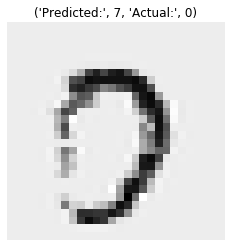

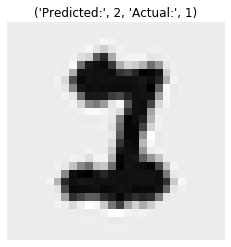

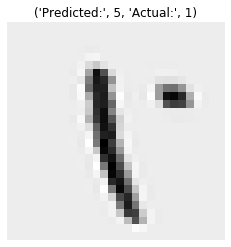

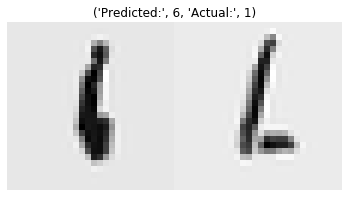

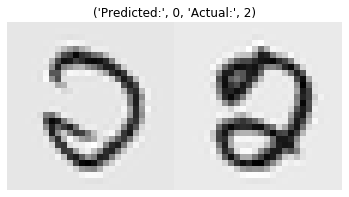

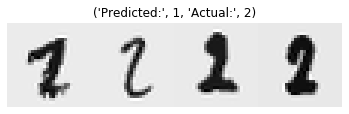

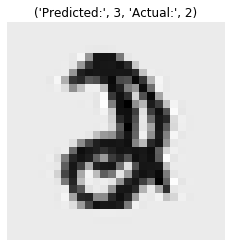

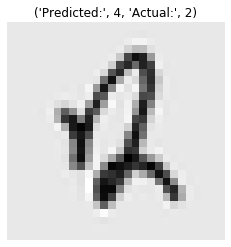

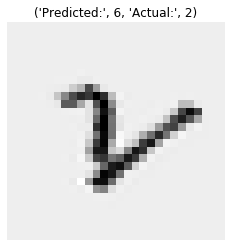

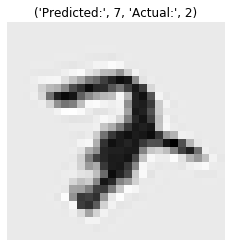

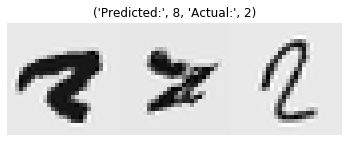

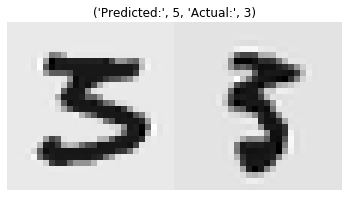

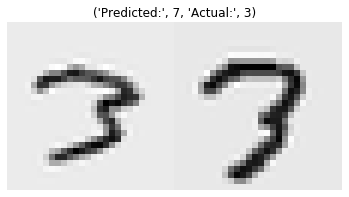

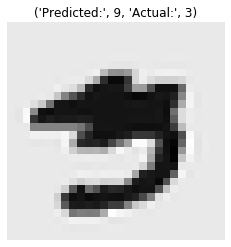

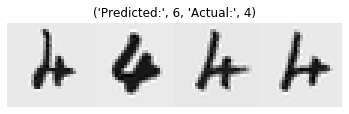

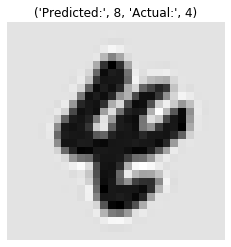

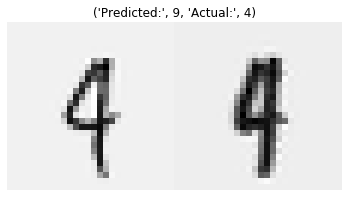

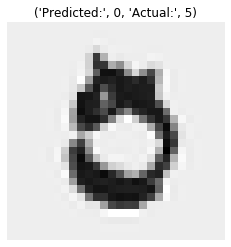

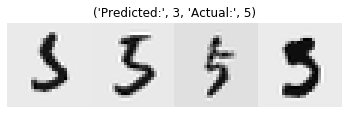

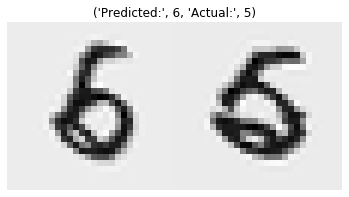

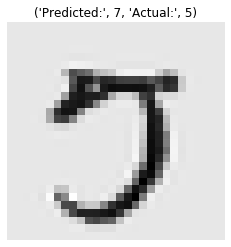

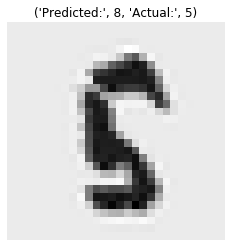

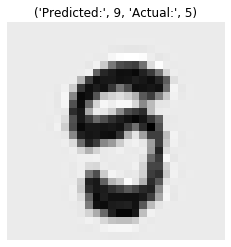

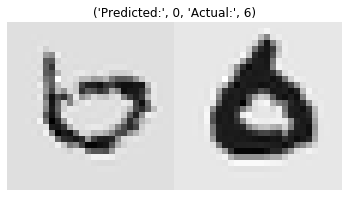

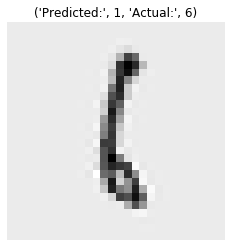

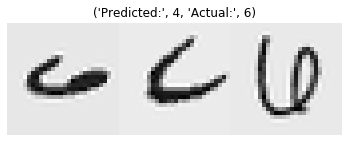

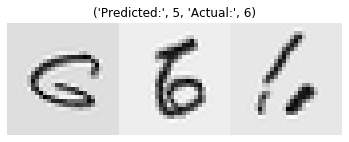

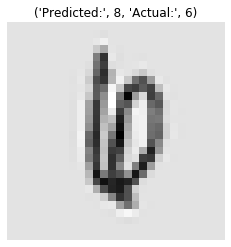

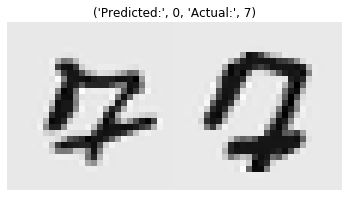

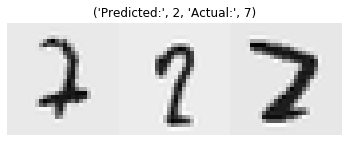

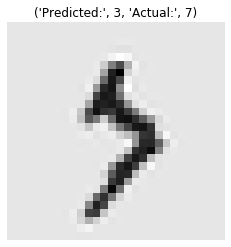

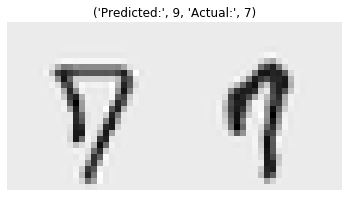

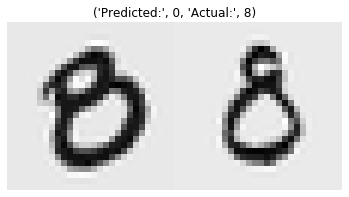

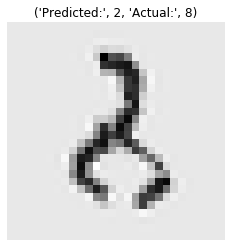

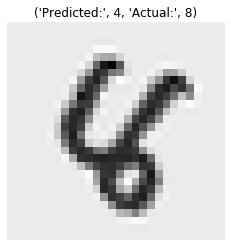

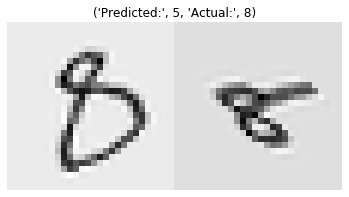

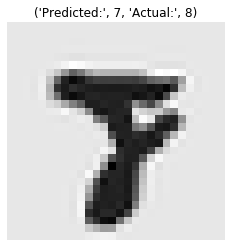

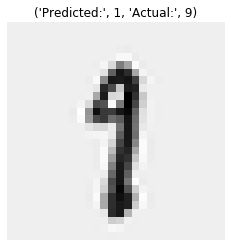

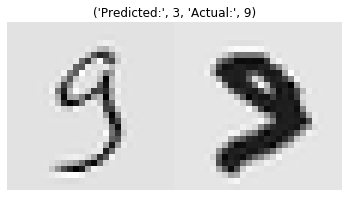

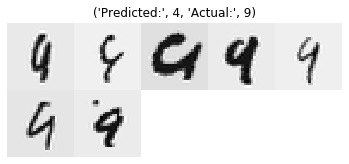

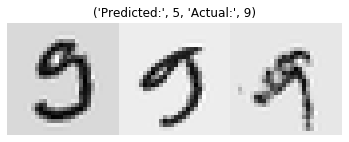

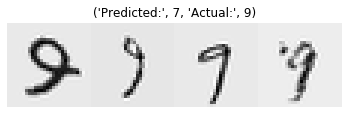

In [65]:
for i in range(10):
    false_negative(i)

## 2-Pixel Translation with Poly Kernel Various Degrees.
### Deskewed, C = 2

In [14]:
X_train_augmented = [image for image in X_train_deskewed]
y_train_augmented = [label for label in y_train_array]

for dx, dy in ((2, 0), (-2, 0), (0, 2), (0, -2)):
    for image, label in zip(X_train_deskewed, y_train_array):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

X_train_augmented.shape

(300000, 784)

In [ ]:
from tqdm import tqdm
start = time.time()

scores_poly_2_pixel = np.empty(10)

for i in tqdm(range(10)):
    svc = SVC(C = 2, kernel = 'poly', degree = i+1 )
    svc.fit(X_train_augmented, y_train_augmented)
    scores_poly_2_pixel[i]=(1-svc.score(X_test_deskewed, y_test))*100
    

print(scores_poly)
print('Best Poly Degree:', np.argmin(scores_poly_2_pixel) + 1)
print('Error %:', np.min(scores_poly_2_pixel))

print((time.time() - start)/60, 'minutes')

  0%|          | 0/10 [00:00<?, ?it/s]

### 1-Pixel Translation with Degree 9 Poly with Deskewed Data

In [ ]:
X_train_augmented = [image for image in X_train_deskewed]
y_train_augmented = [label for label in y_train_array]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train_deskewed, y_train_array):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [32]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

### Degree 9 Deskewed no shift

In [13]:
start = time.time()

svc = SVC(C = 2, kernel = 'poly', degree = 9)
svc.fit(X_train_deskewed, y_train)

print('Degree 9 Poly SVC no pixel translation Error % : ',(1-svc.score(X_test_deskewed, y_test))*100)

print((time.time() - start)/60, 'minutes')

Degree 9 Poly SVC no pixel translation Error % :  2.969999999999995
5.097060783704122 minutes


## TABLES

In [22]:
from prettytable import PrettyTable

field_names = ["Model", "Preprocessing", "Error %", "Total Time Taken"]
x = PrettyTable(field_names)
x.title = "Skewed vs. Deskewed"
x.add_row(["SVC()", "Skewed", 2.08, ''])
x.add_row(["SVC()", "Deskewed on test and train data", 1.38, ''])
x.add_row(["SVC()", "Deskewing only train data", 89.68, ''])
x.add_row(["", "", "", '14.4 minutes'])
print(x)

+-------+---------------------------------+---------+------------------+
| Model |          Preprocessing          | Error % | Total Time Taken |
+-------+---------------------------------+---------+------------------+
| SVC() |              Skewed             |   2.08  |                  |
| SVC() | Deskewed on test and train data |   1.38  |                  |
| SVC() |    Deskewing only train data    |  89.68  |                  |
|       |                                 |         |   14.4 minutes   |
+-------+---------------------------------+---------+------------------+


In [24]:
field_names = ["Kernel", "Error %", "Total Time Taken"]
x = PrettyTable(field_names)
x.title = "Choosing the Kernel with Deskewed Data"
x.add_row(["Linear", 3.62, ''])
x.add_row(["Poly", 1.35, ''])
x.add_row(["Sigmoid", 30.44, ''])
x.add_row(["", "", '22.8 minutes'])
print(x)

+---------+---------+------------------+
|  Kernel | Error % | Total Time Taken |
+---------+---------+------------------+
|  Linear |   3.62  |                  |
|   Poly  |   1.35  |                  |
| Sigmoid |  30.44  |                  |
|         |         |   22.8 minutes   |
+---------+---------+------------------+


In [ ]:
[ 3.62  1.35 30.44]
Best Kernel: poly
Error %: 1.3499999999999956
22.817512281735738 minutes